# ERGM on Two Local Motif Counts (and Edge Density)
The statistics for this directed, spatial ERGM are the usual edge density and the local 3-cycle density
$$t(G) = \frac{\textrm{# of local 3-cycles in G}}{\textrm{# number of local 3-cycles if G were complete}},$$
where a local 3-cycle is a 3-cycle on three nodes $\{i, j, k\}$ in $G$ such that $d(i, j), d(j, k), d(k, i) < r$ for some fixed radius $r$. To be precise, given a directed graph $G$ with no self-loops and adjacency matrix $A$,
$$t(G) = \frac{\operatorname{tr} (M(r) \circ A)^3 / 3}{\operatorname{tr} A^3 / 3},$$
where $\circ$ denotes the element-wise product and $M(r)_{ij} = 1$ if and only if $i \neq j$ and $d(i, j) < r$.

In [2]:
import Pkg
Pkg.activate("..")

  Activating project at `~/research/xaqlab/ergm.jl`


## Define ERGM

In [195]:
using ergm.stats
using LinearAlgebra

n = 50
node_locations = rand(3, 50)
node_metric = [
    norm(node_locations[i] - node_locations[j])
    for i ∈ 1:n, j ∈ 1:n
]
local_radius = 0.2
local_mask = node_metric .< local_radius

max_edge_count = n * (n - 1)
max_local_6_count = sum(local_mask ^ 2 .* local_mask)
max_local_7_count = sum(local_mask ^ 2 .* local_mask') / 3

sufficient_statistics = DeltaStats(
    function(G)
        n = G.n
        A = G.adjacency
        
        edge_count = sum(A)
        edge_density = edge_count / max_edge_count
        
        local_A = local_mask .* A
        local_6_count = sum(local_A ^ 2 .* local_A)
        local_7_count = sum(local_A ^ 2 .* local_A') / 3
        local_6_density = local_6_count / max_local_6_count
        local_7_density = local_7_count / max_local_7_count
        
        [edge_density, local_6_density, local_7_density]
    end,
    function(G, current_statistics, update)
        n = G.n
        A = G.adjacency
        ix, x = update
        i, j = ix
        
        delta_edge_count = x - G[ix]
        delta_edge_density = delta_edge_count / max_edge_count
        
        local_A = local_mask .* A
        delta_local_6_count = (x - G[ix]) * local_mask[i, j] * (sum(local_A[i, :] .* local_A[:, j]) + sum(local_A[i, :] .* local_A[j, :]) + sum(local_A[:, i] .* local_A[:, j]))
        delta_local_7_count = (x - G[ix]) * local_mask[i, j] * sum(local_A[j, :] .* local_A[:, i])
        delta_local_6_density = delta_local_6_count / max_local_6_count
        delta_local_7_density = delta_local_7_count / max_local_7_count
        
        current_statistics .+ [delta_edge_density, delta_local_6_density, delta_local_7_density]
    end
)

DeltaStats(var"#57#59"(), var"#58#60"(), UndefInitializer(), UndefInitializer())

In [196]:
G = DiGraph(rand(n, n) .< 0.3)

DiGraph(Bool[0 0 … 1 1; 0 0 … 1 1; … ; 1 1 … 0 0; 0 0 … 1 0], 50, 0)

In [202]:
s_G = get_stats(sufficient_statistics, G)

for ix ∈ keys(G)
    G2 = copy(G)
    x = 1 - G[ix]
    G2[ix] = x
    a = get_stats(sufficient_statistics, G2)
    b = sufficient_statistics.delta_stats_function(G, s_G, (ix, x))
    
    if maximum(abs.(a - b)) > 1e-10
        print("mismatch at ix = $ix, $(b - a)")
        break
    end
end

In [203]:
# percentage of total possible edges which are considered "local"
(sum(local_mask) - n) / (n * (n - 1)) * 100

36.40816326530612

In [204]:
# percentage of total possible motif 6s which are considered "local"
full_graph = ones(Int, (n, n))
full_graph[diagind(full_graph)] .= 0
sum(local_mask ^ 2 .* local_mask) / sum(full_graph ^ 2 .* full_graph) * 100

12.833333333333332

In [205]:
# percentage of total possible motif 7s which are considered "local"
(sum(local_mask ^ 2 .* local_mask') / 3) / (sum(full_graph ^ 2 .* full_graph') / 3) * 100

12.833333333333336

## Define Ground-Truth Natural Parameters

In [252]:
using ergm.models
using ergm.sampler
using ergm.spaces
using Statistics

θ_gt = [-1e3, -1.2e4, 1e4]
model = ExponentialFamily(sufficient_statistics, θ_gt)
sampler = ParallelGibbsSampler(
    DiGraph(zeros(Bool, n, n)), model, 3, 5, Threads.nthreads()
);

# Verify Ground-Truth is Far From Edros-Renyi

In [253]:
function expectation_ergm(θ)
    m = 100
    update_sampler_params(sampler, θ)
    _, ss = sample(sampler, m)
    mean(ss, dims=2)
end

function expectation_er(p)
    m = 100
    ss = hcat([get_stats(sufficient_statistics, DiGraph(rand(n, n) .< p)) for i ∈ 1:m]...)
    mean(ss, dims=2)
end

expectation_er (generic function with 1 method)

In [254]:
# ground-truth expectation parameters for ERGM
e_ergm = expectation_ergm(θ_gt)

3×1 Matrix{Float64}:
 0.42469795918367764
 0.04377418499867478
 0.15589782666313273

In [255]:
# expectations for Erdos-Renyi with matching density
e_er = expectation_er(e_ergm[1])

3×1 Matrix{Float64}:
 0.4260653061224488
 0.06342035515504901
 0.06335144447389345

In [256]:
# what factor are motif 6s over-represented by relative to Erdos-Renyi?
e_ergm[2] / e_er[2]

0.6902229558894206

In [257]:
# what factor are motif 7s over-represented by relative to Erdos-Renyi?
e_ergm[3] / e_er[3]

2.460840916222152

# Attempt to Recover Ground-Truth Parameters

In [275]:
using ergm.optim
using ergm.inference

update_params(model, θ_gt)
update_sampler_params(sampler, θ_gt)
Gs, _ = sample(sampler, 100)
update_params(model, [0.0, 0.0, 0.0])
optimizer = ADAM(1e2, 0.85, 0.999, 1e-8, [0.0, 0.0, 0.0], 300, 0.0, "log.txt")
θs, Ls, target_Es, Es = mcmc_mle(Gs, model, optimizer, 1000, 5, 3);

## Results for Recovering Expectation Parameters

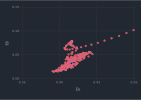

In [281]:
using Gadfly
using DataFrames

Gadfly.push_theme(:dark)
Es_mat = hcat(Es...)
df = DataFrame(:Ee => Es_mat[1, :], :E6 => Es_mat[2, :])
plot(
    layer(x=[target_Es[1]], y=[target_Es[2]], Geom.point, color=[colorant"blue"]),
    layer(df, x=:Ee, y=:E6, Geom.point),
    Guide.xlabel("Ee"), Guide.ylabel("E6")
)

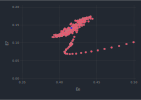

In [282]:
using Gadfly
using DataFrames

Gadfly.push_theme(:dark)
Es_mat = hcat(Es...)
df = DataFrame(:Ee => Es_mat[1, :], :E7 => Es_mat[3, :])
plot(
    layer(x=[target_Es[1]], y=[target_Es[3]], Geom.point, color=[colorant"blue"]),
    layer(df, x=:Ee, y=:E7, Geom.point),
    Guide.xlabel("Ee"), Guide.ylabel("E7")
)

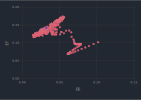

In [284]:
using Gadfly
using DataFrames

Gadfly.push_theme(:dark)
Es_mat = hcat(Es...)
df = DataFrame(:E6 => Es_mat[2, :], :E7 => Es_mat[3, :])
plot(
    layer(x=[target_Es[2]], y=[target_Es[3]], Geom.point, color=[colorant"blue"]),
    layer(df, x=:E6, y=:E7, Geom.point),
    Guide.xlabel("E6"), Guide.ylabel("E7")
)

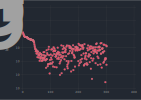

In [289]:
plot(y=Ls, Scale.y_log10, Guide.ylabel("loss"))

## Results for Recovering Natural Parameters

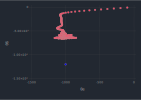

In [290]:
df = DataFrame(:θe => θs[1, :], :θ6 => θs[2, :])
plot(
    layer(df, x=:θe, y=:θ6, Geom.point),
    layer(x=[θ_gt[1]], y=[θ_gt[2]], color=[colorant"blue"])
)

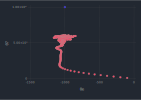

In [291]:
df = DataFrame(:θe => θs[1, :], :θ7 => θs[3, :])
plot(
    layer(df, x=:θe, y=:θ7, Geom.point),
    layer(x=[θ_gt[1]], y=[θ_gt[3]], color=[colorant"blue"])
)

In [105]:
m = 100
update_sampler_params(sampler, θ_gt)
_, ss = sample(sampler, m);

In [116]:
var(ss[3, :])

0.00024141092314088443